# Differentially private random feature models: real data

We test on two real datasets and compare the following methods:

1. Our method
2. Modified Chaudi --  different random noises are added. Does not perform well
3. DPSGD (does not converge to min-norm solution, requires r in theory.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time

from scipy import io
from matplotlib import cm

from DP_RF import *

## Data processing

In [2]:
################ Preprocessing

def one_hot(df, cols): # idk if sklearns one-hot encoder is similar
    """
    df: pandas DataFrame
    param: cols a list of columns to encode 
    return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

def numeric_scaler(df, cols):
    '''
    df: pandas dataframe
    numeric_cols: (array of strings) column names for numeric variables

    no return: does inplace operation
    '''
    df_new = df.copy()
    mmscaler = MinMaxScaler()
    df_new[cols] = mmscaler.fit_transform(df_new[cols])
    return df_new

def numeric_scaler_numpy(arr):
    '''
    arr (numpy array):  
    '''
    mmscaler = MinMaxScaler()
    scaled_arr = mmscaler.fit_transform(arr)
    return scaled_arr
    

In [3]:
# Preprocessing
df_medical = pd.read_csv('insurance.csv')
numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']

df_medical_mm = numeric_scaler(df_medical, numeric_all) # minmax scaling for all numeric columns, so all elements in [0,1]
df_medical_mm_oh = one_hot(df_medical_mm, cat_all)
df_medical_mm_oh.drop(cat_all, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_medical_mm_oh = df_medical_mm_oh * 1.0 # make bool true, false into 1.0, 0.0

X = df_medical_mm_oh.drop('charges', axis=1)
X = X.to_numpy() # now (n, d+1) dimensional, linear regression in d+1 is affine in d
y = df_medical_mm_oh['charges'].to_numpy()

In [4]:
################################# Compare different methods
# number of random features
N_range = range(10000,22000,2000)
gamma = 2

# privacy budget
epsilon = 0.5
# privacy parameter
delta = 1e-5

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.1)
# numner of iterations, also number of training samples
T = np.size(y_train)

# error and time
K = 10   # repeat K times
err_np = np.zeros( (len(N_range), K) )
#err_ours = np.zeros( (len(N_range), K) )
err_KZ = np.zeros( (len(N_range), K) )
err_SGD1_np = np.zeros( (len(N_range), K) )
err_SGD1 = np.zeros( (len(N_range), K) )
err_SGD2_np = np.zeros( (len(N_range), K) )
err_SGD2 = np.zeros( (len(N_range), K) )
err_SGD3_np = np.zeros( (len(N_range), K) )
err_SGD3 = np.zeros( (len(N_range), K) )

#time_our = np.zeros( (len(N_range), K) )
#time_KZ = np.zeros( (len(N_range), K) )
#time_SGD = np.zeros( (len(N_range), K) )

In [6]:
for i in range(len(N_range)):
    
    N = N_range[i]
    Delta_c = 2/np.sqrt(N)    # l2-sensitivity
    
    for j in range(K):
    
        # random feature matrix
        A_train, A_test = RF_Gaussian(gamma, N, x_train, x_test)
    
        # our method: pseudo-inverse
        #start = time.time()
        #c = np.linalg.pinv(A_train) @ y_train   # non-private
        #c_ours = private(c, Delta_c, epsilon, delta, "Gaussian")  # private ours
        #end = time.time()
        #time_our[i,j] = end - start
        #err_np[i,j] = np.linalg.norm(y_test - A_test @ c)**2 / np.size(y_test)
        #err_ours[i,j] = np.linalg.norm(y_test - A_test @ c_ours)**2 / np.size(y_test)
        
        # our method: KZ
        #start = time.time()
        c = randomized_kaczmarz(A_train, y_train, np.zeros((N,)), T)
        c_KZ = private(c, Delta_c, epsilon, delta, "Gaussian")  # private ours
        #end = time.time()
        #time_KZ[i,j] = end - start
        err_np[i,j] = np.linalg.norm(y_test - A_test @ c)**2 / np.size(y_test)
        err_KZ[i,j] = np.linalg.norm(y_test - A_test @ c_KZ)**2 / np.size(y_test)
        
        ## SGD 1
        eta = 1/np.size(y_train)       # learning rate
        c_SGD_np, c_SGD = DPRF_SGD(epsilon, delta, A_train, y_train, T, eta)
        err_SGD1_np[i,j] = np.linalg.norm(y_test - A_test @ c_SGD_np)**2 / np.size(y_test)
        err_SGD1[i,j] = np.linalg.norm(y_test - A_test @ c_SGD)**2 / np.size(y_test)
        
        ## SGD 2
        eta = 1/np.size(y_train)/4      # learning rate
        c_SGD_np, c_SGD = DPRF_SGD(epsilon, delta, A_train, y_train, T, eta)
        err_SGD2_np[i,j] = np.linalg.norm(y_test - A_test @ c_SGD_np)**2 / np.size(y_test)
        err_SGD2[i,j] = np.linalg.norm(y_test - A_test @ c_SGD)**2 / np.size(y_test)
        
        ## SGD 3
        eta = 1/np.size(y_train)/16      # learning rate
        c_SGD_np, c_SGD = DPRF_SGD(epsilon, delta, A_train, y_train, T, eta)
        err_SGD3_np[i,j] = np.linalg.norm(y_test - A_test @ c_SGD_np)**2 / np.size(y_test)
        err_SGD3[i,j] = np.linalg.norm(y_test - A_test @ c_SGD)**2 / np.size(y_test)
    
        ## SGD
        #eta = 1/np.size(y_train)        # learning rate
        #T = np.size(y_train)            # number of iterations
        #start = time.time()
        #c_SGD_np, c_SGD = DPRF_SGD(epsilon, delta, A_train, y_train, T, eta)
        #end = time.time()
        #time_SGD[i,j] = end - start
        #err_SGD_np[i,j] = np.linalg.norm(y_test - A_test @ c_SGD_np)**2 / np.size(y_test)
        #err_SGD[i,j] = np.linalg.norm(y_test - A_test @ c_SGD)**2 / np.size(y_test)

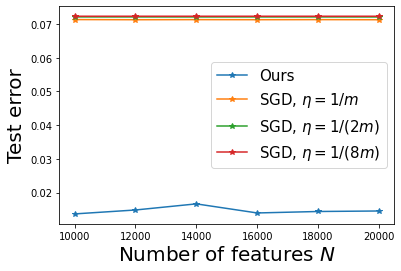

In [7]:
############################# Test error visualization
plt.plot(N_range, np.mean(err_np, axis=1), '-*', label='Ours')
plt.plot(N_range, np.mean(err_SGD1_np,axis=1), '-*', label=r'SGD, $\eta = 1/m$')
plt.plot(N_range, np.mean(err_SGD2_np,axis=1), '-*', label=r'SGD, $\eta = 1/(2m)$')
plt.plot(N_range, np.mean(err_SGD3_np,axis=1), '-*', label=r'SGD, $\eta = 1/(8m)$')
plt.legend(fontsize=15)
plt.ylabel('Test error', size=20)
plt.xlabel(r'Number of features $N$', size=20)
plt.savefig('real1_eta.pdf', bbox_inches = 'tight')

Text(0.5, 0, 'Number of features $N$')

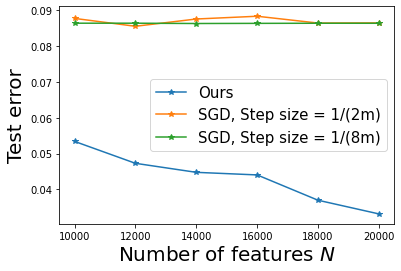

In [44]:
#plt.plot(N_range, np.mean(err_ours,axis=1), '-*', label='Ours:pinv')
plt.plot(N_range, np.mean(err_KZ,axis=1), '-*', label='Ours')
#plt.plot(N_range, np.mean(err_SGD1,axis=1), '-*', label='SGD, Step size = 1/m')
plt.plot(N_range, np.mean(err_SGD2,axis=1), '-*', label='SGD, Step size = 1/(2m)')
plt.plot(N_range, np.mean(err_SGD3,axis=1), '-*', label='SGD, Step size = 1/(8m)')
plt.legend(fontsize=15)
plt.ylabel('Test error', size=20)
plt.xlabel(r'Number of features $N$', size=20)
#plt.savefig('real1_private.pdf', bbox_inches = 'tight')

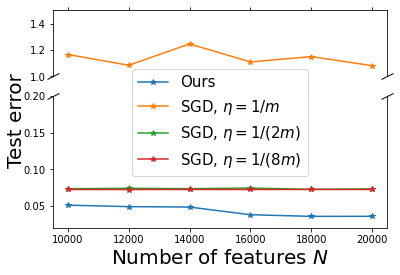

In [9]:
# Plotting function
def plot(ax):
    ax.plot(N_range, np.mean(err_KZ, axis=1), '-*', label='Ours')
    ax.plot(N_range, np.mean(err_SGD1,axis=1), '-*', label=r'SGD, $\eta = 1/m$')
    ax.plot(N_range, np.mean(err_SGD2,axis=1), '-*', label=r'SGD, $\eta = 1/(2m)$')
    ax.plot(N_range, np.mean(err_SGD3,axis=1), '-*', label=r'SGD, $\eta = 1/(8m)$')
    #plt.ylabel('Mean test error', size=20)
    plt.xlabel(r'Number of features $N$', size=20)

# Draw the graph on two subplots
# Bottom graph is twice the size of the top one
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]})
plot(ax1)
plot(ax2)

# Changes graph axes
ax1.set_ylim(1, 1.5) # Top graph
ax2.set_ylim(0.02, 0.2) # Bottom graph

# Hides the spines between the axes
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Adds slanted lines to axes
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle='none',
    color='k',
    mec='k',
    mew=1,
    clip_on=False
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
plt.legend(loc='center',bbox_to_anchor=(0.5, 0.8),fontsize=15)
fig.text(0.02, 0.5, 'Test error', va='center', rotation='vertical', size=20)
plt.savefig('real1_private_eta.pdf', bbox_inches = 'tight')

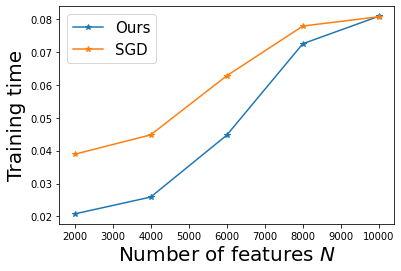

In [12]:
############# Computational time
#plt.plot(N_range, np.mean(time_our,axis=1), '-*', label='Ours: pinv')
#plt.plot(N_range, np.mean(time_KZ,axis=1), '-*', label='Ours')
#plt.plot(N_range, np.mean(time_SGD,axis=1), '-*', label='SGD')
#plt.legend(fontsize=15)
#plt.ylabel('Training time', size=20)
#plt.xlabel(r'Number of features $N$', size=20)
#plt.savefig('real1_time.pdf', bbox_inches = 'tight')

In [9]:
#np.mean(time_our,axis=1), np.mean(time_KZ,axis=1)

(array([0.6115922 , 0.95894735, 1.4395252 , 1.92255747, 2.44323473]),
 array([0.02077639, 0.02589128, 0.04469857, 0.07249353, 0.08084617]))

In [11]:
#np.mean(err_ours,axis=1), np.mean(err_KZ,axis=1)

(array([0.38830921, 0.19499343, 0.14181829, 0.11971103, 0.1126222 ]),
 array([0.28882406, 0.17463576, 0.14234196, 0.12010545, 0.11804873]))

## real data: wine quality

In [10]:
# read data and data processing
wine = pd.read_csv('winequality-red.csv', sep=';')
wine_new = wine.to_numpy()

mmscaler = MinMaxScaler()
wine_new = mmscaler.fit_transform(wine_new)

X = wine_new[:,:11]
y = wine_new[:,-1]

In [11]:
######### Compare different methods
# number of random features
N_range = range(10000,22000,2000)
gamma = 2

# privacy budget
epsilon = 0.5
delta = 1e-5

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.1)
# numner of iterations, also number of training samples
T = np.size(y_train)

# error and time
K = 10   # repeat K times
err_np = np.zeros( (len(N_range), K) )
err_KZ = np.zeros( (len(N_range), K) )
err_SGD1_np = np.zeros( (len(N_range), K) )
err_SGD1 = np.zeros( (len(N_range), K) )
err_SGD2_np = np.zeros( (len(N_range), K) )
err_SGD2 = np.zeros( (len(N_range), K) )
err_SGD3_np = np.zeros( (len(N_range), K) )
err_SGD3 = np.zeros( (len(N_range), K) )


In [12]:
for i in range(len(N_range)):
    
    N = N_range[i]
    Delta_c = 4/np.sqrt(N)    # l2-sensitivity
    
    for j in range(K):
    
        # random feature matrix
        A_train, A_test = RF_Gaussian(gamma, N, x_train, x_test)
        
        # our method: KZ
        c = randomized_kaczmarz(A_train, y_train, np.zeros((N,)), T)
        c_KZ = private(c, Delta_c, epsilon, delta, "Gaussian")  # private ours
        err_np[i,j] = np.linalg.norm(y_test - A_test @ c)**2 / np.size(y_test)
        err_KZ[i,j] = np.linalg.norm(y_test - A_test @ c_KZ)**2 / np.size(y_test)
    
        ## SGD 1
        eta = 1/np.size(y_train)       # learning rate
        c_SGD_np, c_SGD = DPRF_SGD(epsilon, delta, A_train, y_train, T, eta)
        err_SGD1_np[i,j] = np.linalg.norm(y_test - A_test @ c_SGD_np)**2 / np.size(y_test)
        err_SGD1[i,j] = np.linalg.norm(y_test - A_test @ c_SGD)**2 / np.size(y_test)
        
        ## SGD 2
        eta = 1/np.size(y_train)/4      # learning rate
        c_SGD_np, c_SGD = DPRF_SGD(epsilon, delta, A_train, y_train, T, eta)
        err_SGD2_np[i,j] = np.linalg.norm(y_test - A_test @ c_SGD_np)**2 / np.size(y_test)
        err_SGD2[i,j] = np.linalg.norm(y_test - A_test @ c_SGD)**2 / np.size(y_test)
        
        ## SGD 3
        eta = 1/np.size(y_train)/16      # learning rate
        c_SGD_np, c_SGD = DPRF_SGD(epsilon, delta, A_train, y_train, T, eta)
        err_SGD3_np[i,j] = np.linalg.norm(y_test - A_test @ c_SGD_np)**2 / np.size(y_test)
        err_SGD3[i,j] = np.linalg.norm(y_test - A_test @ c_SGD)**2 / np.size(y_test)

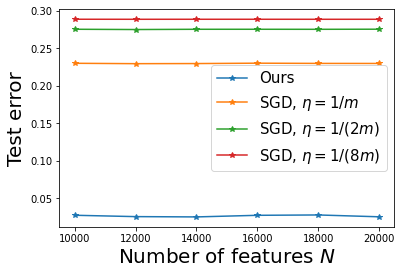

In [13]:
############################# Test error visualization
plt.plot(N_range, np.mean(err_np, axis=1), '-*', label='Ours')
plt.plot(N_range, np.mean(err_SGD1_np,axis=1), '-*', label=r'SGD, $\eta = 1/m$')
plt.plot(N_range, np.mean(err_SGD2_np,axis=1), '-*', label=r'SGD, $\eta = 1/(2m)$')
plt.plot(N_range, np.mean(err_SGD3_np,axis=1), '-*', label=r'SGD, $\eta = 1/(8m)$')
plt.legend(fontsize=15)
plt.ylabel('Test error', size=20)
plt.xlabel(r'Number of features $N$', size=20)
plt.savefig('real2_eta.pdf', bbox_inches = 'tight')

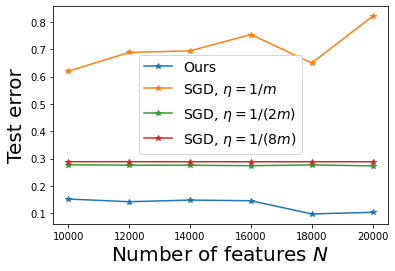

In [25]:
#plt.plot(N_range, np.mean(err_ours,axis=1), '-*', label='Ours:pinv')
plt.plot(N_range, np.mean(err_KZ,axis=1), '-*', label='Ours')
plt.plot(N_range, np.mean(err_SGD1,axis=1), '-*', label=r'SGD, $\eta = 1/m$')
plt.plot(N_range, np.mean(err_SGD2,axis=1), '-*', label=r'SGD, $\eta = 1/(2m)$')
plt.plot(N_range, np.mean(err_SGD3,axis=1), '-*', label=r'SGD, $\eta = 1/(8m)$')
plt.legend(loc='center',bbox_to_anchor=(0.5, 0.55), fontsize=14)
plt.ylabel('Test error', size=20)
plt.xlabel(r'Number of features $N$', size=20)
plt.savefig('real2_private_eta.pdf', bbox_inches = 'tight')

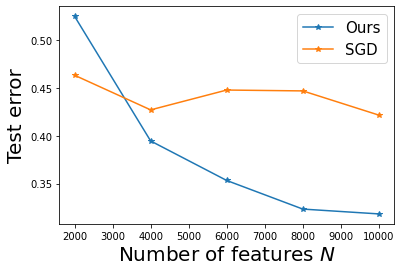

In [17]:
#plt.plot(N_range, np.mean(err_ours,axis=1), '-*', label='Ours:pinv')
plt.plot(N_range, np.mean(err_KZ,axis=1), '-*', label='Ours')
plt.plot(N_range, np.mean(err_SGD,axis=1), '-*', label='SGD')
plt.legend(fontsize=15)
plt.ylabel('Test error', size=20)
plt.xlabel(r'Number of features $N$', size=20)
plt.savefig('real2_private.pdf', bbox_inches = 'tight')

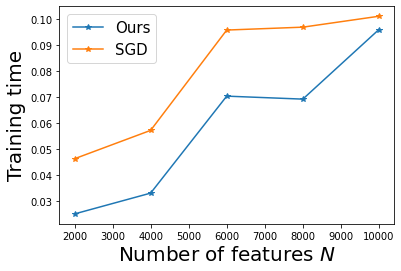

In [21]:
############# Computational time
#plt.plot(N_range, np.mean(time_our,axis=1), '-*', label='Ours: pinv')
plt.plot(N_range, np.mean(time_KZ,axis=1), '-*', label='Ours')
plt.plot(N_range, np.mean(time_SGD,axis=1), '-*', label='SGD')
plt.legend(fontsize=15)
plt.ylabel('Training time', size=20)
plt.xlabel(r'Number of features $N$', size=20)
plt.savefig('real2_time.pdf', bbox_inches = 'tight')

In [19]:
np.mean(time_our,axis=1), np.mean(time_KZ,axis=1)

(array([0.90768561, 1.40932653, 2.07236404, 2.90977383, 3.42578266]),
 array([0.02506354, 0.03306844, 0.07038486, 0.06923735, 0.09601171]))

In [20]:
np.mean(err_ours,axis=1), np.mean(err_KZ,axis=1)

(array([0.7908511 , 0.40796798, 0.33508924, 0.30013547, 0.30609176]),
 array([0.52469043, 0.39449138, 0.35321696, 0.32336525, 0.3183176 ]))